# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [6]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import get_frequency, preprocess

from ccs_tools import dx_multi, pr_multi, core_dtypes_pd

## Data Preparation

In [22]:
import utils
reload(utils)
from utils import preprocess

In [7]:
cohort='ami'
tst_seed=0

In [8]:
all_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [9]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

In [10]:
preprocessed = preprocess(all_df, DX_rarecutpoint=20, PR_rarecutpoint=20)

In [11]:
all_df = preprocessed['int_df']

In [12]:
tst_key = pd.read_csv(path+'cohorts/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

In [13]:
train_df0.shape, all_df.shape

((167841, 180), (187055, 179))

## Multi-Level CCS Codes

### Create the parent pairs

Read the ICD9 CCS multi-level category dictionary file. 

In [28]:
from ccs_tools import dx_label

In [22]:
rare_desc = icd_dict.loc[icd_dict.dgns_cd.isin(rare_code), ['dgns_cd', 'longdesc']]

In [23]:
rare_desc.to_csv(path+'rare_icd9.csv', index=False)

In [31]:
dx_multi.CCS_LVL1_LABEL.value_counts()

Injury and poisoning                                                                 2764
Residual codes; unclassified; all E codes [259. and 260.]                            1589
Diseases of the nervous system and sense organs                                      1587
Infectious and parasitic diseases                                                    1226
Complications of pregnancy; childbirth; and the puerperium                           1205
Neoplasms                                                                            1114
Diseases of the musculoskeletal system and connective tissue                          863
Diseases of the digestive system                                                      757
Mental Illness                                                                        597
Diseases of the circulatory system                                                    553
Diseases of the genitourinary system                                                  498
Endocrine;

## Embedding + NN
### Train embedding with Glove

In [13]:
from glove import Glove

In [14]:
embed_dim=100
count_cap=5

In [15]:
g = Glove(input_dim=len(preprocessed['code_cat']), embedding_dim=embed_dim, count_cap=count_cap)

In [16]:
g.update_cooccur(train_df0[['DX1']+DXs+PRs])

Updating co-occurrence matrix from a Dataframe with 167841 rows...
Finished. It takes 28.1 seconds to update the cooccurrences.


In [17]:
cooccur_df = g.get_cooccur_df()

In [25]:
cooccur_df.shape

(755859, 3)

In [18]:
parent_pairs = preprocessed['parent_pairs']

In [19]:
g.train_glove(cooccur_df=cooccur_df, cache_path=model_path, epochs=50, earlystop_patience=10, reducelr_patience=3, 
              parent_pairs=parent_pairs, lamb=0., metric='cosine')

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/50
755859/755859 [==============================] - 12s 16us/step - loss: 0.9639
Epoch 2/50
755859/755859 [==============================] - 6s 8us/step - loss: 0.2160
Epoch 3/50
755859/755859 [==============================] - 6s 8us/step - loss: 0.1665
Epoch 4/50
755859/755859 [==============================] - 6s 8us/step - loss: 0.1402
Epoch 5/50
755859/755859 [==============================] - 6s 8us/step - loss: 0.1237
Epoch 6/50
755859/755859 [==============================] - 6s 8us/step - loss: 0.1124
Epoch 7/50
755859/755859 [==============================] - 6s 8us/step - loss: 0.1044
Epoch 8/50
755859/755859 [==============================] - 6s 8us/step - loss: 0.0982
Epoch 9/50
755859/755859 [==============================] - 6s 8us/step - loss: 0.0932
Epoch 10/50
755859/755859 [==============================] - 6s 8us/step - loss: 0.0890
Epoch 11/50
755859/755859 [==========================

In [20]:
embed_mat = g.get_embed_mat()

In [73]:
embed_mat.shape

(2845, 100)

In [21]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [22]:
code_freq = get_frequency(train_df0)

In [23]:
DX_freq = code_freq['DX']

In [36]:
DX_embed_mat = embed_mat[DX_dict[DX_cat[0]]:(DX_dict[DX_cat[-1]]+1), :]

In [106]:
tsne = TSNE(n_components=2, init='random', random_state=0)

In [107]:
start = time.time()
DX_tsne = tsne.fit_transform(DX_embed_mat)
print('Time used: {} sec'.format(time.time()-start))

Time used: 12.861217975616455 sec


In [108]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1]), index=DX_cat)

CCS category labels:

In [109]:
plot_df = plot_df.assign(ccs_lvl1=[dx_multi.loc[dx, 'CCS_LVL1']+' '+dx_multi.loc[dx, 'CCS_LVL1_LABEL'] for dx in plot_df.index])

plot_df = plot_df.assign(freq=DX_freq.loc[pd.Series(DX_cat).apply(lambda x:DX_dict[x])].values)

plot_df = plot_df.assign(dot_size=plot_df.freq.apply(lambda x:np.log(x+1)**2/4))

In [110]:
plot_df.head(10)

,x,y,ccs_lvl1,freq,dot_size
00845,0.346615,-10.029301,9 Diseases of the digestive system,775,11.069436
0088,-0.975292,1.552279,9 Diseases of the digestive system,151,6.309844
0090,-11.902381,12.548748,9 Diseases of the digestive system,28,2.834670
0340,-10.670600,5.479787,8 Diseases of the respiratory system,25,2.653798
0380,-3.543179,-8.233874,1 Infectious and parasitic diseases,79,4.800539
03811,-3.778248,-7.824812,1 Infectious and parasitic diseases,78,4.773019
03812,-3.887542,-7.579182,1 Infectious and parasitic diseases,59,4.190914
03819,-4.284256,-7.362296,1 Infectious and parasitic diseases,29,2.892036
03840,-7.559226,4.634594,1 Infectious and parasitic diseases,22,2.457831
03842,-1.898336,-10.761314,1 Infectious and parasitic diseases,101,5.347593


In [111]:
groups = plot_df.groupby('ccs_lvl1')
gkey = groups.size().sort_values(ascending=False).index

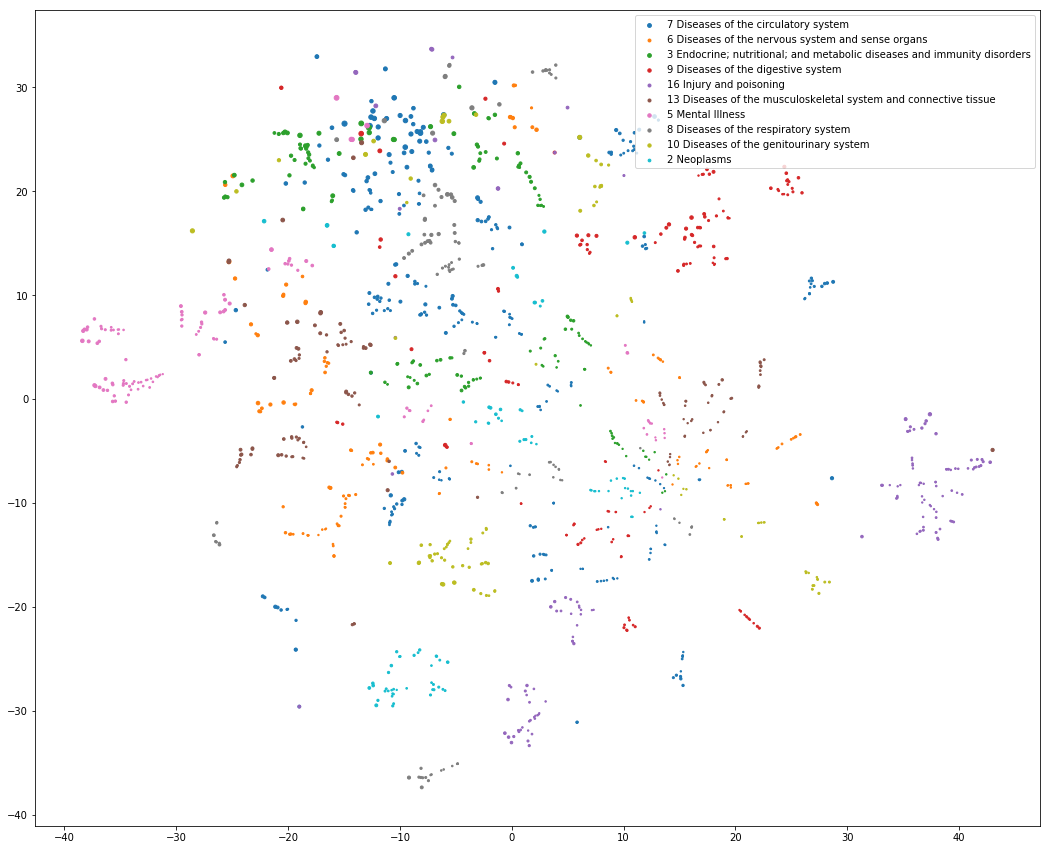

In [102]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in gkey[:10]:
    group = groups.get_group(name)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=name)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('output/embed.png', dpi=200)

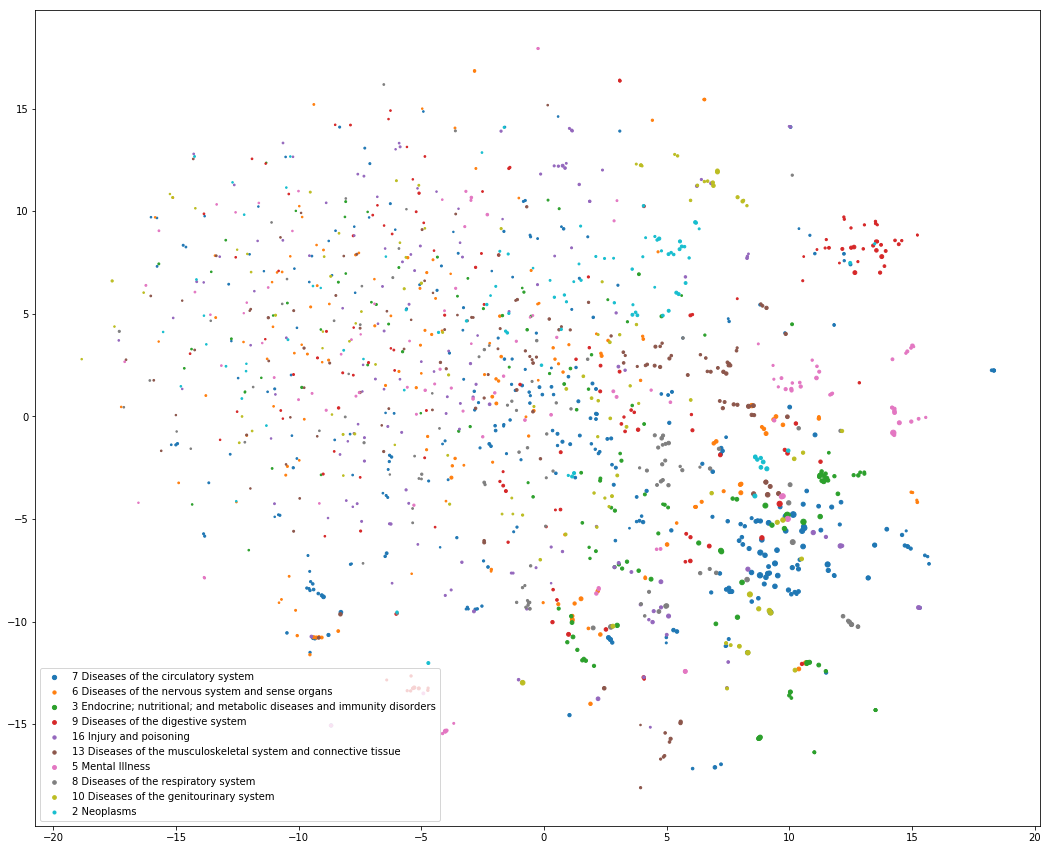

In [112]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in gkey[:10]:
    group = groups.get_group(name)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=name)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('output/embed.png', dpi=200)

In [26]:
bias_mat = g.get_bias_mat()

In [28]:
all_freq = pd.concat([code_freq['DX1'], code_freq['DX'], code_freq['PR']], axis=0)

In [29]:
all_freq = all_freq.sort_index().drop(0)

In [30]:
code_bias_mat = bias_mat[1:(len(DX1_cat)+len(DX_cat)+len(PR_cat)+1), :]

In [32]:
code_bias_mat.shape, all_freq.shape

((2134, 1), (2134,))

In [38]:
from collections import defaultdict

In [39]:
marg_dict = defaultdict(float)

for _, row in cooccur_df.iterrows():
    marg_dict[row.focal_index] += row.cooccur_counts
    marg_dict[row.context_index] += row.cooccur_counts

In [51]:
marg_freq = np.array(list(marg_dict.values()))

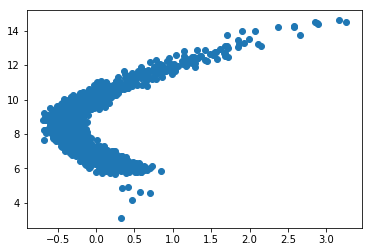

In [54]:
plt.scatter(code_bias_mat[:, 0], np.log(marg_freq))

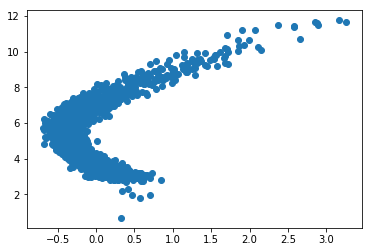

In [56]:
plt.scatter(code_bias_mat[:, 0], np.log(all_freq.values))

In [57]:
cooccur_df.head()

,focal_index,context_index,cooccur_counts
0,1151,604,2.0
1,1082,437,13.0
2,1428,153,11.0
3,1117,103,6.0
4,1006,901,3.0


### Data formating

In [25]:
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()

DX1_array_tst = tst_df['DX1'].values
DX_mat_tst = tst_df[DXs].values
PR_mat_tst = tst_df[PRs].values

hosp_array_tst = tst_df['HOSP_NRD'].values
    
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst, transfer_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [23]:
n_fold = 5

In [24]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)

In [25]:
trn_idx, val_idx = next(skf.split(train_df0, train_df0.HOSP_NRD))

In [26]:
train_df = train_df0.copy()

In [27]:
DX1_array_train = train_df['DX1'].values
            
DX1_array_trn = DX1_array_train[trn_idx]
DX1_array_val = DX1_array_train[val_idx]

DX_mat_train = train_df[DXs].values
            
DX_mat_trn = DX_mat_train[trn_idx, :]
DX_mat_val = DX_mat_train[val_idx, :]

PR_mat_train = train_df[PRs].values
            
PR_mat_trn = PR_mat_train[trn_idx, :]
PR_mat_val = PR_mat_train[val_idx, :]

In [28]:
hosp_array_train = train_df['HOSP_NRD'].values
    
hosp_array_trn = hosp_array_train[trn_idx]
hosp_array_val = hosp_array_train[val_idx]

In [29]:
demo_mat_train = train_df[['AGE', 'FEMALE']].values
demo_mat_train[:, 0] = (demo_mat_train[:, 0]-age_mean)/age_std
pay1_mat_train = to_categorical(train_df.PAY1.values)[:, 1:]
los_array_train = (train_df.LOS.values - los_mean)/los_std
ed_mat_train = to_categorical(train_df.HCUP_ED.values)
zipinc_mat_train = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat_train = to_categorical(train_df.SAMEDAYEVENT.values)
other_mat_train = np.concatenate((demo_mat_train, pay1_mat_train, los_array_train.reshape(los_array_train.shape+(1,)), 
                                ed_mat_train, zipinc_mat_train, transfer_mat_train), axis=1)

other_mat_trn = other_mat_train[trn_idx, :]
other_mat_val = other_mat_train[val_idx, :]

y_train = train_df.readm30.astype(int).values
Y_trn = to_categorical(y_train[trn_idx])
Y_val = to_categorical(y_train[val_idx])

### Model Building

In [48]:
import setsum_layer
reload(setsum_layer)

<module 'setsum_layer' from '/home/wsliu/Codes/DLproj/NRD/setsum_layer.py'>

In [49]:
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling

In [31]:
code_embed_dim = 100
md_width = 128
fc_width = 512
hosp_embed_dim = 1
dropout = 0.3
job_index = 0
batchsize = 512

In [32]:
embed_initializer = Constant(embed_mat)

Model building: 
- setsum_nn 
- setsum_lr
- embed_sum
- embed_pool

In [61]:
model_name = 'embed_pool'

In [62]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                      name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
input_DX = Input(shape = (len(DXs),))
DX_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='DX_embed')(input_DX)
if model_name=='setsum_nn' or 'setsum_lr':
    DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
    DX_embed = MaskedSum()(DX_embed)
elif model_name=='embed_sum':
    DX_embed = MaskedSum()(DX_embed)
elif model_name=='embed_pool':
    DX_embed = MaskedPooling()(DX_embed)
input_PR = Input(shape = (len(PRs),))
PR_embed = Embedding(input_dim=len(code_cat), output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='PR_embed')(input_PR)
if model_name=='setsum_nn' or 'setsum_lr':
    PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
    PR_embed = MaskedSum()(PR_embed)
elif model_name=='embed_sum':
    PR_embed = MaskedSum()(PR_embed)
elif model_name=='embed_pool':
    PR_embed = MaskedPooling()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_train.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed, input_other])
if model_name=='setsum_nn':
    merged = Dense(fc_width, activation='relu')(merged)
    merged = Dropout(dropout)(merged)
prediction = Dense(2, activation='softmax')(merged)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [63]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed':
        l.trainable = False

In [64]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [65]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'embeding_nn_temp'+str(job_index)+'.h5', validation_y=Y_val[:, 1], 
                                 validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [59]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [66]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                     batch_size=batchsize, epochs=10, callbacks=[auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                     validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                    verbose=1)

Train on 133832 samples, validate on 34009 samples
Epoch 1/10
133832/133832 [==============================] - 2s 16us/step - loss: 1.3728 - val_loss: 0.5843
AUC: 0.6799

Epoch 2/10
133832/133832 [==============================] - 2s 13us/step - loss: 1.2951 - val_loss: 0.6433
AUC: 0.6960

Epoch 3/10
133832/133832 [==============================] - 2s 13us/step - loss: 1.2782 - val_loss: 0.5689
AUC: 0.7024

Epoch 4/10
133832/133832 [==============================] - 2s 13us/step - loss: 1.2693 - val_loss: 0.5827
AUC: 0.7067

Epoch 5/10
133832/133832 [==============================] - 2s 13us/step - loss: 1.2626 - val_loss: 0.5445
AUC: 0.7074

Epoch 6/10
133832/133832 [==============================] - 2s 13us/step - loss: 1.2592 - val_loss: 0.6756
AUC: 0.7100

Epoch 7/10
133832/133832 [==============================] - 2s 13us/step - loss: 1.2536 - val_loss: 0.5976
AUC: 0.7122

Epoch 8/10
133832/133832 [==============================] - 2s 13us/step - loss: 1.2569 - val_loss: 0.5928
AU

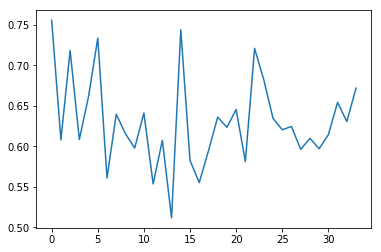

In [39]:
plt.plot(hist.history['val_loss'])

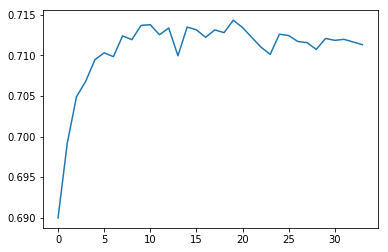

In [40]:
plt.plot(auccheckpoint.auc_history)

In [41]:
model.load_weights(model_path+'embeding_nn_temp'+str(job_index)+'.h5')

In [42]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

19214/19214 [==============================] - 1s 43us/step


{0: 0.7097647732762336}

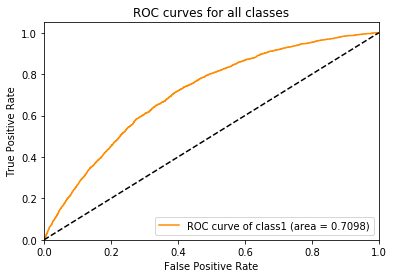

In [43]:
plot_roc(y_pred, y_true)

## Train with One-Hot-Encoding

In [55]:
DX1_cat = preprocessed['DX1_cat']
DX_cat = preprocessed['DX_cat']
PR_cat = preprocessed['PR_cat']
DX1_dict = preprocessed['DX1_dict']
DX_dict = preprocessed['DX_dict']
PR_dict = preprocessed['PR_dict']
code_cat = preprocessed['code_cat']
hosp_cat = preprocessed['hosp_cat']
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()

In [32]:
code_mat_tst = tst_df[['DX1']+DXs+PRs].values
code_ohe_tst = np.zeros((len(tst_df), len(code_cat)))
for i in range(code_mat_tst.shape[0]):
    for j in range(code_mat_tst.shape[1]):
        if not code_mat_tst[i,j]==0:
            code_ohe_tst[i, code_mat_tst[i,j]] = 1.

In [56]:
hosp_array_tst = tst_df['HOSP_NRD'].values
hosp_ohe_tst = np.zeros((len(tst_df), len(hosp_cat)))
for j, hosp in enumerate(hosp_array_tst):
    hosp_ohe_tst[j, hosp] = 1.

In [59]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst, transfer_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [63]:
n_fold=3

In [64]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)

In [65]:
trn_idx, val_idx = next(skf.split(train_df0, train_df0.HOSP_NRD))

In [69]:
train_df = train_df0.copy()

In [85]:
code_mat_train = train_df[['DX1']+DXs+PRs].values
code_ohe_train = np.zeros((len(train_df), len(code_cat)))
for i in range(code_mat_train.shape[0]):
    for j in range(code_mat_train.shape[1]):
        if not code_mat_train[i,j]==0:
            code_ohe_train[i, code_mat_train[i,j]] = 1.
            
code_ohe_trn = code_ohe_train[trn_idx, :]
code_ohe_val = code_ohe_train[val_idx, :]

In [73]:
hosp_array_train = train_df['HOSP_NRD'].values
hosp_ohe_train = np.zeros((len(train_df), len(hosp_cat)))
for j, hosp in enumerate(hosp_array_train):
    hosp_ohe_train[j, hosp] = 1.
    
hosp_ohe_trn = hosp_ohe_train[trn_idx, :]
hosp_ohe_val = hosp_ohe_train[val_idx, :]

In [75]:
demo_mat_train = train_df[['AGE', 'FEMALE']].values
demo_mat_train[:, 0] = (demo_mat_train[:, 0]-age_mean)/age_std
pay1_mat_train = to_categorical(train_df.PAY1.values)[:, 1:]
los_array_train = (train_df.LOS.values - los_mean)/los_std
ed_mat_train = to_categorical(train_df.HCUP_ED.values)
zipinc_mat_train = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat_train = to_categorical(train_df.SAMEDAYEVENT.values)
other_mat_train = np.concatenate((demo_mat_train, pay1_mat_train, los_array_train.reshape(los_array_train.shape+(1,)), 
                                ed_mat_train, zipinc_mat_train, transfer_mat_train), axis=1)

other_mat_trn = other_mat_train[trn_idx, :]
other_mat_val = other_mat_train[val_idx, :]

y_train = train_df.readm30.astype(int).values
Y_trn = to_categorical(y_train[trn_idx])
Y_val = to_categorical(y_train[val_idx])

### Model Building

In [93]:
fc_width1 = 1024
fc_width2 = 256
dropout = 0.3
lr = 1e-4
batchsize = 512

In [94]:
input_code = Input(shape = (len(code_cat),))
input_hosp = Input(shape=(len(hosp_cat),))
input_other = Input(shape=(other_mat_train.shape[1], ))

merged = Concatenate(axis=1)([input_code, input_hosp, input_other])

x = Dense(fc_width1, activation='relu')(merged)
x = Dense(fc_width2, activation='relu')(x)
x = Dropout(dropout)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_code, input_hosp, input_other], outputs=prediction)

In [95]:
adam = Adam(lr=lr)
model.compile(optimizer=adam, loss='categorical_crossentropy')    

In [96]:
auccheckpoint = AUCCheckPoint(filepath=model_path+'ohe_temp.h5', validation_y=Y_val[:, 1], 
                            validation_x=[code_ohe_val, hosp_ohe_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [97]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [98]:
hist = model.fit([code_ohe_trn, hosp_ohe_trn, other_mat_trn], Y_trn, 
                     batch_size=batchsize, epochs=5, callbacks=[auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                     validation_data=[[code_ohe_val, hosp_ohe_val, other_mat_val], Y_val], verbose=1)

Train on 111558 samples, validate on 56283 samples
Epoch 1/5
111558/111558 [==============================] - 6s 55us/step - loss: 1.2705 - val_loss: 0.6081
AUC: 0.7145

Epoch 2/5
111558/111558 [==============================] - 5s 47us/step - loss: 1.2121 - val_loss: 0.6304
AUC: 0.7153

Epoch 3/5
111558/111558 [==============================] - 5s 47us/step - loss: 1.1628 - val_loss: 0.6129
AUC: 0.7097

Epoch 4/5
111558/111558 [==============================] - 5s 47us/step - loss: 1.0916 - val_loss: 0.6359
AUC: 0.6957

Epoch 5/5
111558/111558 [==============================] - 5s 47us/step - loss: 0.9802 - val_loss: 0.5691
AUC: 0.6664



In [99]:
model.load_weights(model_path+'ohe_temp.h5')

In [100]:
y_output = model.predict([code_ohe_tst, hosp_ohe_tst, other_mat_tst], verbose=0)  

In [104]:
y_pred = y_output[:, 1]
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

In [105]:
roc_auc

0.7117707427053499

### backups

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [9]:
freq = get_frequency(train_df0)

In [10]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [11]:
DX_rarecutpoint = 10
PR_rarecutpoint = 10

In [12]:
DX1_cat = sorted(freq['DX1'].index)
DX_cat = sorted(freq['DX'].loc[(freq['DX']>DX_rarecutpoint) & (~freq['DX'].index.isin(unclassified)) & 
                               (~freq['DX'].index.isin(['invl', 'incn']))].index)
PR_cat = sorted(freq['PR'].loc[(freq['PR']>PR_rarecutpoint) & (~freq['PR'].index.isin(['invl', 'incn']))].index)

In [14]:
len(DX1_cat), len(DX_cat), len(PR_cat)

(20, 2231, 413)

In [13]:
dx1_multi_sub = dx_multi.loc[dx_multi.ICD9CM_CODE.isin(DX1_cat)]
dx1_ccs_cat = sorted(pd.concat([dx1_multi_sub['CCS_LVL'+str(j)] for j in range(1, 5)]).unique())
if '' in dx1_ccs_cat:
    dx1_ccs_cat.remove('')
dx_multi_sub = dx_multi.loc[dx_multi.ICD9CM_CODE.isin(DX_cat)]
dx_ccs_cat = sorted(pd.concat([dx_multi_sub['CCS_LVL'+str(j)] for j in range(1, 5)]).unique())
if '' in dx_ccs_cat:
    dx_ccs_cat.remove('')

pr_multi_sub = pr_multi.loc[pr_multi.ICD9CM_CODE.isin(PR_cat)]
pr_ccs_cat = sorted(pd.concat([pr_multi_sub['CCS_LVL'+str(j)] for j in range(1, 4)]).unique())
if '' in pr_ccs_cat:
    pr_ccs_cat.remove('')

In [14]:
code_cat = DX1_cat+DX_cat+PR_cat+dx1_ccs_cat+dx_ccs_cat+pr_ccs_cat

In [15]:
DX1_dict = dict(zip(DX1_cat, range(1, len(DX1_cat)+1)))
DX_dict = dict(zip(DX_cat, range(len(DX1_cat)+1, len(DX1_cat)+len(DX_cat)+1)))
PR_dict = dict(zip(PR_cat, range(len(DX1_cat)+len(DX_cat)+1, len(DX1_cat)+len(DX_cat)+len(PR_cat)+1)))
DX1_dict['missing'] = 0
DX_dict['missing'] = 0
PR_dict['missing'] = 0
dx1_ccs_dict = dict(zip(dx1_ccs_cat, range(len(DX1_cat)+len(DX_cat)+len(PR_cat)+1, 
                                          len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+1)))
dx_ccs_dict = dict(zip(dx_ccs_cat, range(len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+1, 
                                         len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+len(dx_ccs_cat)+1)))
pr_ccs_dict = dict(zip(pr_ccs_cat, range(len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+len(dx_ccs_cat)+1, 
                                        len(DX1_cat)+len(DX_cat)+len(PR_cat)+len(dx1_ccs_cat)+len(dx_ccs_cat)+len(pr_ccs_cat)+1)))

In [16]:
hosp_cat = sorted(all_df['HOSP_NRD'].value_counts().index)
hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

In [18]:
int_df = all_df.copy()

In [19]:
int_df.loc[~int_df.DX1.isin(DX1_cat), 'DX1'] = 'missing'

int_df['DX1'] = int_df['DX1'].map(DX1_dict)

In [20]:
for dx in DXs:
    int_df.loc[~int_df[dx].isin(DX_cat), dx] = 'missing'
    int_df[dx] = int_df[dx].map(DX_dict)

In [21]:
for pr in PRs:
    int_df.loc[~int_df[pr].isin(PR_cat), pr] = 'missing'
    int_df[pr] = int_df[pr].map(PR_dict)

In [22]:
int_df['HOSP_NRD'] = int_df['HOSP_NRD'].map(hosp_dict)